In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import itertools

from scipy.spatial import cKDTree
from scipy         import sparse
from scipy.sparse  import linalg as sparse_linalg
from numba         import njit

In [2]:
dimension = 1
npoints   = 5
nfreqs    = 1
nrays     = 1
nboundary = 1

In [3]:
boundary2point = np.array([0])
point2boundary = np.array([npoints for _ in range(npoints)])
point2boundary[0] = 0

rs     = np.array([i for i in range(npoints)])
xs_blk = np.array([[r,0,0] for r in rs])
xs_bdy = xs_blk[boundary2point]
xs     = xs_blk[:,:dimension]

eta                = np.array([[1.0] for _ in range(npoints  )])
chi                = np.array([[1.0] for _ in range(npoints  )])
boundary_condition = np.array([[1.0] for _ in range(nboundary)])
boundary_normal    = np.array([[-1.0, 0.0, 0.0]])

In [4]:
ncp = 3 #npoints #64

dis_blk, red_blk = cKDTree(xs_blk).query(xs_blk, ncp)
dis_bdy, red_bdy = cKDTree(xs_bdy).query(xs_bdy, ncp)

dis_bdy = dis_bdy[:,:nboundary]
red_bdy = red_bdy[:,:nboundary]

dis_blk = dis_blk[:,:npoints]
red_blk = red_blk[:,:npoints]

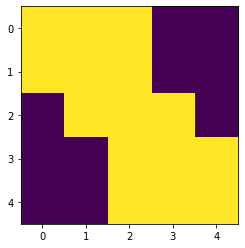

In [5]:
mat = np.zeros((npoints, npoints))
for i, ids in enumerate(red_blk):
    for j in ids:
        mat[i,j] = 1.0
plt.imshow(mat)

In [6]:
red_blk

array([[0, 1, 2],
       [1, 2, 0],
       [2, 3, 1],
       [3, 4, 2],
       [4, 3, 2]])

In [7]:
@njit
def get_neighbors(i):
    if   (i == 0):
        return [1]
    elif (i == npoints-1):
        return [npoints-2]
    else:
        return [i-1, i+1]

In [8]:
def get_hs_stats():
    """
    Returns for each point the distance to its farthest neighbour,
    and the average distance to all its neighbours.
    """
    # Initialize a new array
    hs_min  = np.zeros(npoints)
    hs_mean = np.zeros(npoints)
    # Loop over all points
    for i in range(npoints):
        # Get distances to neighbours.
        dist = np.linalg.norm(xs[i] - xs[get_neighbors(i)], axis=1)
        hs_min [i] = np.max (dist)
        hs_mean[i] = np.mean(dist)
    return hs_min, hs_mean

In [9]:
hs_min, hs_mean = get_hs_stats()

Computing the gradient based on nearest neighbor information based on Meyer, Eriksson, and Maggio (2001).
For a point at position $\textbf{x}_{i}$, and nearest neighbors $\textbf{x}_{j}$, we can observe that
\begin{equation}
f_{j} - f_{i} \ = \ \left(\textbf{x}_{j} - \textbf{x}_{i} \right) \cdot \nabla f_{i}
\end{equation}

\begin{equation}
\Delta f \ = \ \Delta \textbf{x} \cdot \nabla f
\end{equation}

\begin{equation}
\nabla f \ = \
\left( \Delta \textbf{x} ^{\text{T}} \Delta \textbf{x} \right)^{-1} \ \Delta \textbf{x}^{\text{T}} \Delta f
\end{equation}

In [10]:
def get_grad(ys, xs):
    # Initialize a new array
    grad_ys = np.zeros(xs.shape)
    # In 1D use basic finite difference.    
    if (xs.shape[1] == 1):
        # Unpack xs
        xs = xs[:,0]
        # Finite difference
        dy = np.diff(ys)
        dx = np.diff(xs)
        # Go to second order.
        dy1 = np.concatenate((dy,      [dy[-1]]))
        dy2 = np.concatenate(([dy[0]], dy      ))
        dx1 = np.concatenate((dx,      [dx[-1]]))
        dx2 = np.concatenate(([dx[0]], dx      ))
        # Compose gradient.
        grad_ys = (dy1 + dy2) / (dx1 + dx2)
    # In 2D & 3D use Meyer, Eriksson, and Maggio (2001).
    else:
        # Loop over all points.
        for i in range(npoints):
            nb = get_neighbors(i)
            dx = xs[i] - xs[nb]
            dy = ys[i] - ys[nb]
            grad_ys[i] = np.matmul(np.linalg.inv(np.matmul(dx.T, dx)), np.matmul(dx.T, dy))        
    # return grad
    return grad_ys

In [11]:
# Define the (tabulated) scale function
hs = 4.5*hs_min

# Get the gradient of the log of the (tabulated) scale function 
dlog_hs = get_grad(np.log10(hs), xs)

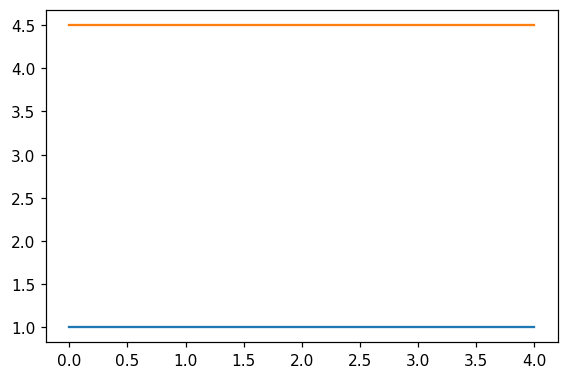

In [12]:
plt.figure(dpi=110)
plt.plot(np.linalg.norm(xs_blk, axis=1), hs_min)
plt.plot(np.linalg.norm(xs_blk, axis=1), hs)
# plt.xscale('log')
# plt.yscale('log')

In [13]:
@njit
def RBF_hexp(r):
    """
    Minus half exponential kernel.
    """
    # Ensure to take the absolute value
    rr = np.abs(r)
    # Compute hexp kernel
    return np.exp(-0.5*rr)

@njit
def grad_RBF_hexp(r):
    return -0.50 * RBF_hexp(r)

@njit
def grad2_RBF_hexp(r):
    return +0.25 * RBF_hexp(r)

Consider a kernel, $k$, of the form
\begin{equation}
k(x,y) \ = \ K \left( \frac{\|x - y\|^2}{h(x) \, h(y)} \right).
\end{equation}
Then one can compute
\begin{equation}
\partial_{y}k(x,y) \ = \ -\frac{1}{h(x) \, h(y)} \left(2\left(x-y\right) + \left(x-y\right)^{2} \partial_{y} \log h(y)\right) K' \left( \frac{\|x - y\|^2}{h(x) \, h(y)} \right).
\end{equation}

In [14]:
# Define kernel
KK       = RBF_hexp
grad_KK  = grad_RBF_hexp
grad2_KK = grad2_RBF_hexp

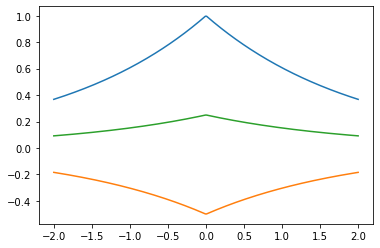

In [15]:
x = np.linspace(-2, 2, 250)

Ks   = [      KK(r) for r in x]
gKs  = [ grad_KK(r) for r in x]
g2Ks = [grad2_KK(r) for r in x]

plt.plot(x,   Ks)
plt.plot(x,  gKs)
plt.plot(x, g2Ks)

In [16]:
# @njit
def kernel(i1, i2):
    """
    k(x1,x2) = K(|x1-x2|^2 / h(x1)h(x2))
    """
    d = xs[i1] - xs[i2]
    r = np.dot(d,d) / (hs[i1] * hs[i2])
    return KK(r)

# @njit
def d1_kernel(i1, i2):
    """
    ∂k(x1,x2)/∂x2
    """
    d = xs[i1] - xs[i2]
    a = 1.0 / (hs[i1] * hs[i2])
    r = np.dot(d,d) * a
    return (-2.0*d*a - r*dlog_hs[i2]) * grad_KK(r)

# @njit
def d2_kernel(i1, i2):
    """
    ∂k(x1,x2)/∂x1
    """
    d = xs[i1] - xs[i2]
    a = 1.0 / (hs[i1] * hs[i2])
    r = np.dot(d,d) * a
    return (+2.0*d*a - r*dlog_hs[i1]) * grad_KK(r)

# @njit
def d1d2_kernel(i1, i2):
    """
    ∂∂k(x1,x2)/∂x1∂x2
    """
    d = xs[i1] - xs[i2]
    a = 1.0 / (hs[i1] * hs[i2])
    r = np.dot(d,d) * a
    term1 = - 2.0 * a * (1.0 + d*(dlog_hs[i2] - dlog_hs[i1])) \
            - r * dlog_hs[i1] * dlog_hs[i2] 
    term2 =  (+2.0*d*a - r*dlog_hs[i1]) \
            *(-2.0*d*a - r*dlog_hs[i2])
    return term1*grad_KK(r) + term2*grad2_KK(r)

In [17]:
# Specify dimensions of (sub-spaces of) the domain
xdim_blk = [npoints,   nfreqs, nrays]
xdim_bdy = [nboundary, nfreqs, nrays]
# Specify dimensions of (sub-spaces of) the codomain
ydim_blk = [1]
ydim_bdy = [1]
# Get total dims
dims_blk = xdim_blk + ydim_blk
dims_bdy = xdim_bdy + ydim_bdy
# Initialize indices and reductions
inds_blk = [np.arange(dim) for dim in dims_blk]
inds_bdy = [np.arange(dim) for dim in dims_bdy]
# (Optionally) specify reductions of sub-spaces
# Set default for reductions
REDS_blk = [np.arange(dim) for dim in dims_blk]
def reds_blk(ii):
    REDS_blk[0] = red_blk[ii[0]]
    return REDS_blk
REDS_bdy = [np.arange(dim) for dim in dims_bdy]
def reds_bdy(ii):
    REDS_bdy[0] = red_bdy[ii[0]]
    return REDS_bdy
# Get dimensions of linearised spaces
dim_blk = np.prod(dims_blk)
dim_bdy = np.prod(dims_bdy)
dim_tot = dim_blk + dim_bdy
# Get indices of linearised spaces
linds_blk = np.arange(dim_blk).reshape(dims_blk)
linds_bdy = np.arange(dim_bdy).reshape(dims_bdy)

def bdy_2_blk(ii):
    ii = list(ii)
    ii[0] = boundary2point[ii[0]]
    return tuple(ii)

In [18]:
def get_datsize_S22():

    # Set index
    index = 0

    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        ii1     = linds_bdy[ii1_bdy]
        for ii2_bdy in itertools.product(*reds_bdy(ii1_bdy)):    
            ii2_blk = bdy_2_blk(ii2_bdy)
            ii2     = linds_bdy[ii2_bdy]
            if (ii1 <= ii2):
                index += 1
                if (ii1 < ii2):
                    index += 1

    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)): 
            index += 2
            
    for ii1_blk in itertools.product(*inds_blk):
        ii1 = linds_blk[ii1_blk] + dim_bdy
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk] + dim_bdy
            if (ii1 <= ii2):
                index += 1
                if (ii1 < ii2):
                    index += 1
                    
    return index+1


def get_datsize_S12():

    # Set index
    index = 0
    
    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        ii1     = linds_bdy[ii1_bdy]
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk]
            index += 1

    for ii1_blk in itertools.product(*inds_blk):
        ii1 = linds_blk[ii1_blk]
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk] + dim_bdy
            index += 1
                    
    return index+1

In [19]:
datsize_S22 = get_datsize_S22()
datsize_S12 = get_datsize_S12()

print('S12 size:', datsize_S12)
print('S22 size:', datsize_S22)

S12 size: 19
S22 size: 23


In [20]:
# @njit
def k (ii1, ii2):
    # Unpack indices
    p1, p2 = ii1[0], ii2[0]
    f1, f2 = ii1[1], ii2[1]
    r1, r2 = ii1[2], ii2[2]
    z1, z2 = ii1[3], ii2[3]
    # Apply operator
    return kernel(p1, p2)

# @njit
def B1_k(ii1, ii2):
    """
    B1 k(x1,x2) = k(x1,x2)
    """
    return k(ii1, ii2)

# @njit
def L1_k(ii1, ii2):
    """
    L1 k(x1,x2) = (1 + ∇1/χ1) k(x1,x2)
    """
    # Unpack indices
    p1, p2 = ii1[0], ii2[0]
    f1, f2 = ii1[1], ii2[1]
    r1, r2 = ii1[2], ii2[2]
    z1, z2 = ii1[3], ii2[3]
    # Apply operator
    return kernel(p1,p2) + d1_kernel(p1,p2) / chi[p1,f1]

# @njit
def B1B2_k(ii1, ii2):
    """
    B1 B2 k(x1,x2) = k(x1,x2)
    """
    return k(ii1, ii2)

# @njit
def L1B2_k(ii1, ii2):
    """
    L1 B2 k(x1,x2) = L1 k(x1,x2)
    """
    return L1_k(ii1,ii2)

# @njit
def L1L2_k(ii1, ii2):
    """
    L1 L2 k(x1,x2) = (1 + ∇1/χ1) (1 + ∇2/χ2) k(x1,x2)
    """
    # Unpack indices
    p1, p2 = ii1[0], ii2[0]
    f1, f2 = ii1[1], ii2[1]
    r1, r2 = ii1[2], ii2[2]
    z1, z2 = ii1[3], ii2[3]
    # Apply operator
    return         kernel(p1,p2)              \
            +   d2_kernel(p1,p2) / chi[p2,f2] \
            +   d1_kernel(p1,p2) / chi[p1,f1] \
            + d1d2_kernel(p1,p2) / chi[p1,f1] / chi[p2,f2]

In [21]:
# # @njit
# def B1_k(ii1, ii2):
#     """
#     B1 k(x1,x2) = (1 + ∇1/χ1) k(x1,x2)
#     """
#     # Unpack indices
#     p1, p2 = ii1[0], ii2[0]
#     f1, f2 = ii1[1], ii2[1]
#     r1, r2 = ii1[2], ii2[2]
#     z1, z2 = ii1[3], ii2[3]
#     # Apply operator
#     if (np.dot(boundary_normal[point2boundary[p1]], Rs[r1]) < 0.0):
#         if (z2 == 0):
#             return +kernel(p1,p2)
#         else:
#             return +kernel(p1,p2)
#     else:
#         if (z2 == 0):
#             return +kernel(p1,p2)
#         else:
#             return -kernel(p1,p2)
        
# # @njit
# def L1_k(ii1, ii2):
#     """
#     L1 k(x1,x2) = (1 + ∇1/χ1) k(x1,x2)
#     """
#     # Unpack indices
#     p1, p2 = ii1[0], ii2[0]
#     f1, f2 = ii1[1], ii2[1]
#     r1, r2 = ii1[2], ii2[2]
#     z1, z2 = ii1[3], ii2[3]
#     # Apply operator
#     if (z1 == 0):
#         if (z2 == 0):
#             return d1_kernel(p1,p2)
#         else:
#             return kernel(p1,p2)
#     else:
#         if (z2 == 0):
#             return kernel(p1,p2)
#         else:
#             return d1_kernel(p1,p2)


# # @njit
# def B1B2_k(ii1, ii2):
#     """
#     B1 B2 k(x1,x2) = (1 + ∇1/χ1) k(x1,x2)
#     """
#     # Unpack indices
#     p1, p2 = ii1[0], ii2[0]
#     f1, f2 = ii1[1], ii2[1]
#     r1, r2 = ii1[2], ii2[2]
#     z1, z2 = ii1[3], ii2[3]
#     # Apply operator
#     if (np.dot(boundary_normal[point2boundary[p1]], Rs[r1]) < 0.0):
#         if (z2 == 0):
#             return 2.0 * kernel(p1,p2)
#         else:
#             return 0.0
#     else:
#         if (z2 == 0):
#             return 0.0
#         else:
#             return 2.0 * kernel(p1,p2)

# # @njit
# def L1B2_k(ii1, ii2):
#     """
#     L1 B2 k(x1,x2) = (1 + ∇1/χ1) k(x1,x2)
#     """
#     # Unpack indices
#     p1, p2 = ii1[0], ii2[0]
#     f1, f2 = ii1[1], ii2[1]
#     r1, r2 = ii1[2], ii2[2]
#     z1, z2 = ii1[3], ii2[3]
#     # Apply operator
#     if (np.dot(boundary_normal[point2boundary[p1]], Rs[r1]) < 0.0):
#         if (z2 == 0):
#             return +kernel(p1,p2) + d1_kernel(p1,p2) / chi[p1,f1]
#         else:
#             return +kernel(p1,p2) + d1_kernel(p1,p2) / chi[p1,f1]
#     else:
#         if (z2 == 0):
#             return -kernel(p1,p2) + d1_kernel(p1,p2) / chi[p1,f1]
#         else:
#             return +kernel(p1,p2) - d1_kernel(p1,p2) / chi[p1,f1]
            

# # @njit
# def L1L2_k(ii1, ii2):
#     """
#     L1 L2 k(x1,x2) = [ 1 + (∇1/χ1) (∇2/χ2)  (∇1/χ1)  +  (∇2/χ2) ] 
#                      [ (∇1/χ1)  +  (∇2/χ2)  1 + (∇1/χ1) (∇2/χ2) ] k(x1,x2)
#     """
#     # Unpack indices
#     p1, p2 = ii1[0], ii2[0]
#     f1, f2 = ii1[1], ii2[1]
#     r1, r2 = ii1[2], ii2[2]
#     z1, z2 = ii1[3], ii2[3]
#     # Apply operator
#     if (z1 == z2):
#         return kernel(p1,p2) + d1d2_kernel(p1,p2) / (chi[p1,f1] * chi[p2,f2])
#     else:
#         return d2_kernel(p1,p2) / chi[p2,f2] + d1_kernel(p1,p2) / chi[p1,f1]

In [22]:
# @njit
def get_Sigma12():
    """
    Σ12 = [ B(1) k(xb,xi)  L(1) k(xa,xi) ]
    """
    # initialize
    data = np.zeros(datsize_S12, dtype=np.float64)
    id_1 = np.zeros(datsize_S12, dtype=np.int64)
    id_2 = np.zeros(datsize_S12, dtype=np.int64)
    # set index
    index = 0
    
    for ii2_bdy in itertools.product(*inds_bdy):
        ii2_blk = bdy_2_blk(ii2_bdy)
        ii2     = linds_bdy[ii2_bdy]
        for ii1_blk in itertools.product(*reds_blk(ii2_blk)):
            ii1 = linds_blk[ii1_blk]
            # Compute element
            Bk = B1_k(ii1_blk, ii2_blk)
            # Add element
            data[index] = Bk
            id_1[index] = ii1
            id_2[index] = ii2
            index += 1

    for ii1_blk in itertools.product(*inds_blk):
        ii1 = linds_blk[ii1_blk]
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk] + dim_bdy
            # Compute element
            Lk = L1_k(ii1_blk, ii2_blk)
            # Add element
            data[index] = Lk
            id_1[index] = ii1
            id_2[index] = ii2
            index += 1

    return (data, (id_1, id_2))


def get_Sigma22():
    """
    Σ22 = [ B(1) k(xb,xb) B(2)  L(1) k(xa,xb) B(2) ]
          [ B(1) k(xb,xa) L(2)  L(1) k(xa,xa) L(2) ]
    """
    # Initialize
    data = np.zeros(datsize_S22, dtype=np.float64)
    id_1 = np.zeros(datsize_S22, dtype=np.int64)
    id_2 = np.zeros(datsize_S22, dtype=np.int64)
    # Set index
    index = 0

    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        ii1     = linds_bdy[ii1_bdy]
        for ii2_bdy in itertools.product(*reds_bdy(ii1_bdy)):    
            ii2_blk = bdy_2_blk(ii2_bdy)
            ii2     = linds_bdy[ii2_bdy]
            if (ii1 <= ii2):
                # Compute element
                BB = B1B2_k(ii1_blk, ii2_blk)
                # Add upper triangular part
                data[index] = BB
                id_1[index] = ii1
                id_2[index] = ii2
                index += 1
                if (ii1 < ii2):
                    # Add lower triangular part
                    data[index] = BB
                    id_1[index] = ii2
                    id_2[index] = ii1
                    index += 1

    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        ii1     = linds_bdy[ii1_bdy]
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk] + dim_bdy   
            # Compute element
            LB = L1B2_k(ii1_blk, ii2_blk)
            # Add upper triangular part
            data[index] = LB
            id_1[index] = ii1
            id_2[index] = ii2
            index += 1
            # Add lower triangular part
            data[index] = LB
            id_1[index] = ii2
            id_2[index] = ii1 
            index += 1
            
    for ii1_blk in itertools.product(*inds_blk):
        ii1 = linds_blk[ii1_blk] + dim_bdy
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk] + dim_bdy
            if (ii1 <= ii2):
                # Compute element
                LL = L1L2_k(ii1_blk, ii2_blk)
                # Add upper triangular part
                data[index] = LL
                id_1[index] = ii1
                id_2[index] = ii2
                index += 1
                if (ii1 < ii2):
                    # Add lower triangular part
                    data[index] = LL
                    id_1[index] = ii2
                    id_2[index] = ii1
                    index += 1
                    
    # Return the data
    return (data, (id_1, id_2))


# @njit
def get_condition():
    """
    condition = [ boundary condition ]
                [ operator condition ] 
    """
    # initialize
    condition = np.zeros(dim_tot)

    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        ii1     = linds_bdy[ii1_bdy]
        # Set boundary condition
        condition[ii1] = 1.0 #boundary_condition[ii1_bdy]
        
    for ii1_blk in itertools.product(*inds_blk):
        ii1 = linds_blk[ii1_blk] + dim_bdy
        # Set operator condition
        condition[ii1] = 0.0 #operator_condition[ii1_blk]

    return condition

In [23]:
SIGMA22 = get_Sigma22()
Sigma22 = sparse.coo_matrix(SIGMA22, shape=(dim_tot, dim_tot)).tocsc()

In [24]:
hs

array([4.5, 4.5, 4.5, 4.5, 4.5])

In [25]:
xs

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [26]:
print(Sigma22.todense())

[[1.         1.         0.92743266 0.81647814 0.         0.        ]
 [1.         1.04938272 1.02141012 0.94185648 0.         0.        ]
 [0.92743266 1.02141012 1.04938272 1.02141012 0.         0.        ]
 [0.81647814 0.94185648 1.02141012 1.04938272 1.02141012 0.        ]
 [0.         0.         0.         1.02141012 1.04938272 1.02141012]
 [0.         0.         0.         0.         1.02141012 1.04938272]]


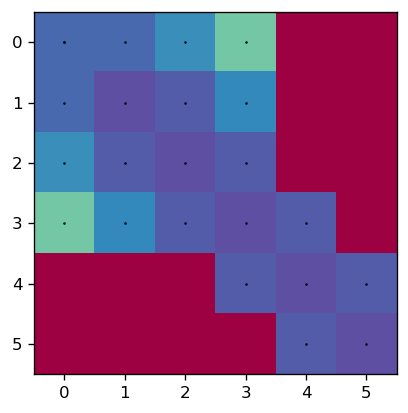

In [27]:
vmin = -np.max(np.abs(Sigma22.todense()))
vmax = +np.max(np.abs(Sigma22.todense()))
plt.figure(dpi=120)
plt.imshow(Sigma22.todense(), cmap='Spectral')
plt.scatter(SIGMA22[1][1], SIGMA22[1][0], c='k', marker='.', s=1)

In [28]:
np.linalg.det(Sigma22.todense())

-0.0005626621228802414

In [29]:
SIGMA12 = get_Sigma12()
Sigma12 = sparse.coo_matrix(SIGMA12, shape=(dim_blk, dim_tot)).tocsc()

In [30]:
print(Sigma12.todense())

[[1.         1.         0.92743266 0.81647814 0.         0.        ]
 [0.97561098 1.0237893  1.         0.92743266 0.         0.        ]
 [0.90595519 0.         1.0237893  1.         0.92743266 0.        ]
 [0.         0.         0.         1.0237893  1.         0.92743266]
 [0.         0.         0.         0.99543225 1.0237893  1.        ]]


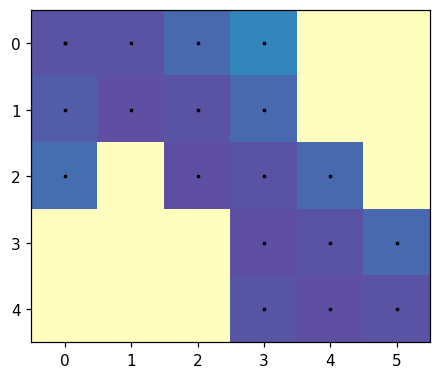

In [33]:
vmin = -np.max(np.abs(Sigma12.todense()))
vmax = +np.max(np.abs(Sigma12.todense()))
plt.figure(dpi=110)
plt.imshow(Sigma12.todense(), cmap='Spectral', vmin=vmin, vmax=vmax)
plt.scatter(SIGMA12[1][1], SIGMA12[1][0], c='k', marker='X', s=2)

In [34]:
condition = get_condition()
condition

array([1., 0., 0., 0., 0., 0.])

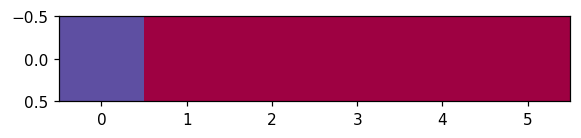

In [35]:
plt.figure(dpi=110)
plt.imshow([condition], cmap='Spectral')

In [40]:
weight = sparse.linalg.spsolve(Sigma22, condition)
result = Sigma12.dot(weight)
result

array([ 1.00000000e+00,  3.28171182e-01,  1.97375994e+02, -2.77496691e-02,
        2.21548294e-03])

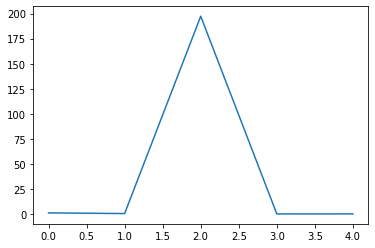

In [41]:
plt.plot(rs, result)